In [36]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

#This is the guideline that should be followed to add this tensorflow directory.

tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs
)

In [37]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [39]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [40]:
len(dataset)

68

this shows the length as 68 because we created the batches of 32 for whole dataset. So 32*68=2176 Here one batch is added even it does not contain full 32 images. that's why it shows more data than it is.

In [41]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 2 1 0 0 0 1 0 1 1 1 0 1 0]


Here it says there is 32 images and each is 256*256 size and 3 rgb channels are there.

In [42]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy().shape)

(256, 256, 3)


If we want to visualize the images

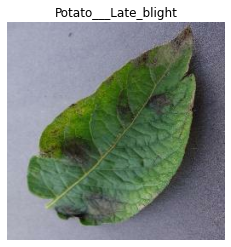

In [43]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    #to display the class name of this image
    
    plt.title(class_names[label_batch[0]])

#to display the 12 images of 1st batch

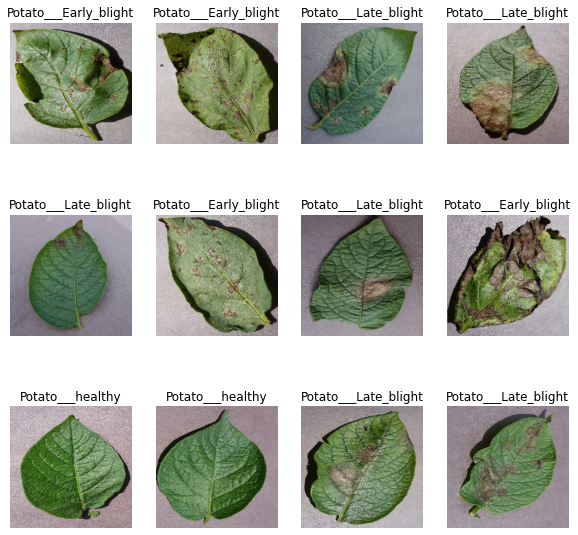

In [44]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
    #to display the class name of this image
    
        

Now the dataset will devide as training and testing.

80% will go to training
20% will go for, 10% for validation and 10% for testing

After every epoch the validation is done with the 10% data.

after the every epoch the model accuracy will be tested using  the testing 10% data.

In [45]:
#to find the number of batches that will be used for the training dataset, the 80% should be multiplied by the  number of batches.
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [46]:
#so there are 54 batches used as the training dataset
train_ds = dataset.take(54)       #this is lke python list arr(:54)
len(train_ds)

54

In [47]:
remain_ds = dataset.skip(54)
len(remain_ds)
#this skipping is like python list, arr(54:)

14

In [48]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [49]:
test_ds = remain_ds.take(6)
len(test_ds)

6

In [50]:
val_ds = remain_ds.skip(6)
len(val_ds)

8

But all of these can be done using the following function

In [51]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return  train_ds, val_ds, test_ds

In [52]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [53]:
len(train_ds)

54

In [54]:
len(val_ds)

6

In [55]:
len(test_ds)

8

#prefetching should be done to speed the traininig

In [56]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Scaling should be done before the training. Resizingthe image size and the randomization is done. Because if there is an image with another dimention, this wil resize the image for the 256*256

In [60]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

The data augmentatioin should be done to robust the code. If there is an image it can be feeded adding more filters like contrast, horizontal flip, rotation, zoom etc. So the model will be trained to that 5 samples instead of 1 image. Here we have used a random flip and a rotation of 0.2.

In [58]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

There are 3 layers in this.
1) size_and_rescale layer
2) data_augmentation layer
3) Conv2D layer- This means the convolution layer

The Conv2D is the convolutional layer. The code should follow the followings

tf.keras.layers.Conv2D(
    
    filters,       #this means the number of filters that have to be represented in this. It should be take randomly. And adjust accordingly.
    
    kernel_size,   #this is same as the size of the actual filter size. here the filter size is taken as 3x3.
    
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

The sequence of this model should be like follows.
    1)initial layes like:     resize_and_rescale and data_augmentation,
    2)convolution layer with relu
    3)poling layer
    (2 and 3 will be repeated according to the accuracy testings)
    4)flattern the data
    5)add dense layer
    6)final layer


In [69]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
                  ])

model.build(input_shape=input_shape)

In [70]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [72]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [73]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/50
54/54 [==============================] - 172s 2s/step - loss: 0.9090 - accuracy: 0.5278 - val_loss: 0.8782 - val_accuracy: 0.4948
Epoch 2/50
54/54 [==============================] - 119s 2s/step - loss: 0.7168 - accuracy: 0.6863 - val_loss: 0.5977 - val_accuracy: 0.7604
Epoch 3/50
54/54 [==============================] - 134s 2s/step - loss: 0.4881 - accuracy: 0.7899 - val_loss: 0.4911 - val_accuracy: 0.8229
Epoch 4/50
54/54 [==============================] - 124s 2s/step - loss: 0.3277 - accuracy: 0.8733 - val_loss: 0.3092 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 132s 2s/step - loss: 0.3130 - accuracy: 0.8750 - val_loss: 0.2941 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 121s 2s/step - loss: 0.2450 - accuracy: 0.9010 - val_loss: 0.2843 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 132s 2s/step - loss: 0.2156 - accuracy: 0.9138 - val_loss: 0.1475 - val_accuracy: 0.9375
Epoch 8/50
54

In [74]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 13s 541ms/step - loss: 0.0558 - accuracy: 0.9805


In [75]:
scores

[0.055794697254896164, 0.98046875]

In [76]:
history

In [78]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])